[![Open In Colab](./images/colab-badge.png)](https://colab.research.google.com/github/abrsvn/pyactr-book/blob/master/notebooks/22_basics_of_pymc3_and_normal_priors.ipynb)

The code so far:

In [1]:
# uncomment the lines below to install the correct version of pymc3 and dependencies
# !pip3 install --upgrade 'arviz==0.11.1'
# !pip3 install --upgrade 'pymc3==3.9.3'

In [2]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

import pandas as pd
import pymc3 as pm

In [3]:
url = 'https://github.com/abrsvn/pyactr-book/blob/master/data/every_each.csv?raw=true'
every_each = pd.read_csv(url)
every_each["quant"] = every_each["quant"].astype('category')
every_each.shape

(347, 2)

In [4]:
every_each.head(n=3)

,logRTresid,quant
0,0.056128,each
1,0.241384,each
2,0.056128,every


In [5]:
every_each.iloc[[0, 8, 18, 31], :]

,logRTresid,quant
0,0.056128,each
8,0.869077,every
18,-0.073706,every
31,-0.187536,each


In [6]:
np.min(every_each["logRTresid"]), np.max(every_each["logRTresid"])

(-0.678407840683957, 1.19278354190761)

## Prior beliefs and the basics of `pymc3`

The way Bayesian estimation works is as follows.

- we start with a prior belief about the quantities of interest, in our case:
    - the mean RT for _every_
    - the mean difference in RTs between _each_ and _every_
- 'prior' beliefs means that these are our beliefs before we see that data
- these beliefs take the form of full probability distributions:
    - we say what values are possible for the quantities of interest
    - we also say which of the possible values are plausible (_before_ we see the data)

- we then update these prior beliefs with the data stored in the `"logRTresid"` and `"quant"` columns in our data set
- upon exposure to the data, we shift/update our prior beliefs in the direction of the data
- the result of this update consists of two _posterior_ probability distributions:
    - one for the mean RTs for _every_
    - the other for the difference in RTs between the two quantifiers
    
- the posterior beliefs/probability distributions are a weighted average of the prior beliefs and the data:
    - if our prior beliefs are very strong (not the case here; see below), the posterior beliefs will reflect the data to a smaller extent
    - if we have a lot of data, and the data has low variability, the posterior beliefs will reflect the data to a larger, or even overwhelming, extent

We have very weak prior beliefs about the quantities of interest. 

- we know that residualized log RTs, or RTs for short, are very roughly between $-3$ and $3$
- one way to formalize this is to take our prior belief for the mean RTs for _every_ to be a normal (Gaussian) distribution centered at $0$ and with a standard deviation (which is a measure of dispersion) of $10$
- this prior belief effectively says that the mean (residualized log) RTs for _every_ are, as far as we are concerned and before seeing the data, anywhere between about $-30$ and $30$ ($+/-$ 3 standard deviations from the mean)
    - most likely somewhere between $-20$ and $20$
    - values below $-30$ or above $30$ are possible, but really unlikely
- this is a very low information and very weakly constraining prior, given our knowledge about what our data transformations (log + residualization by word length and word position) do to self-paced reading RTs
    - self-paced reading RTs are usually between 300 and 600 ms (participants read about 3 words per second)
    - after log-transforming and residualizing these RTs, we get very small values clustered around 0 and spanning the $[-2, 2]$ interval most of the time
    - in our prior, we very liberally allow for values in the $[-30, 30]$ interval

Let's plot a normal distribution with a standard deviation of $10$. We'll take this opportunity to introduce the basics of ```pymc3``` models.

- below, we first create a model ```every_each_model``` using the ```pm.Model()``` method (line 1)
- then, we start specifying the model components; in our case, we are simply interested in a normally distributed variable called ```'normal_density'```
- we create this variable with the corresponding ```pymc3``` probability density function (line 3)
- when we call this function, we need to redundantly specify the name of the variable (not really redundantly, but let's not worry about that), and then provide the parameters for the probability density function:
    - the mean of the normal is set to $0$
    - the standard deviation is set to $10$.

In [7]:
every_each_model = pm.Model()

with every_each_model:
    normal_density = pm.Normal('normal_density', mu=0, sd=10)

We then ask ```pymc3``` to sample $5000$ draws from each of these two distributions using some advanced sampling magic that we won't worry about.

- if you're really curious, take a look at this blog post: [http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/](http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/)

In [8]:
from pymc3.backends import Text
from pymc3.backends.text import load

with every_each_model:
    trace = pm.sample(draws=5000, tune=500, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [normal_density]


Sampling 4 chains for 500 tune and 5_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.


- the sampling procedure is supposed to self-tune for $500$ iterations

We plot the results below:

- we initialize the figure by indicating that we will have one plot, or 'axis system', which we call ```ax```
- this plot will be displayed in a grid consisting of 1 column and 1 row (```ncols=1, nrows=1```); this specification is superfluous here, but it is useful when we have more than one plot to display
- the total figure size is set to $5.5$ by $3.5$ inches
- lines 3-5 plot the histogram of the normal samples and label the plot accordingly
- line 6 tightens up / suitably shrinks all the blank spaces in the figure

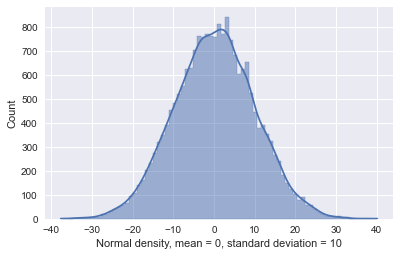

In [9]:
fig, ax = plt.subplots(ncols=1, nrows=1)
fig.set_size_inches(5.5, 3.5)
sns.histplot(trace['normal_density'], element='step',
             kde=True, ax=ax)
ax.set_xlabel('Normal density, mean = 0, standard deviation = 10')
plt.tight_layout(pad=0.5, w_pad=0.2, h_pad=0.7)

As expected for a normal density centered at $0$ and with a standard deviation of $10$:

- most of the probability mass (area under the curve) is spread over the $(-30, 30)$ interval, i.e., within +/- 3 standard deviations of the mean

We will use this normal density as our prior for the mean RT for _every_, which is a very weak, noncommittal prior.

## The prior for the difference in RTs

We can now turn to specifying the prior for the difference in RTs between _every_ and _each_.  This difference could be:

- positive: the mean RT for _each_ is greater than the one for _every_
- negative: the mean RT for _each_ is less than the one for _every_
- $0$: the mean RTs for _each_ and _every_ RTs are the same

Whether $0$, negative or positive, this difference cannot be larger than $6$ in absolute value:

- we know that log RT residual values are roughly between $-3$ and $3$ (and are usually very close to $0$)
- in the unlikely event that the mean RT for _each_ happens to be $3$ and the one for _every_ happens to be $-3$, we'll get a difference of $6$ (or $-6$ if the two values are flipped)
- this is already very unlikely, and the _a priori_ probability of more extreme values for the difference is practically $0$
- tt is therefore reasonable to once again specify our prior for the difference in RTs as a normal distribution with a mean of $0$ and a standard deviation of $10$

## A closer look at the plot of the normal prior

- the shaded area under the dark-blue curve is probability mass
- the curve itself plots probability _density_
    - that is, for any point on the $x$-axis, the height of the curve at that point (i.e., the corresponding value on the $y$-axis) does _not_ plot the probability of that $x$-axis value
    - the height of the curve does _not_ provide the probability mass associated with that $x$-axis value
    
- technically, there is $0$ probability mass associated with any single point on the $x$-axis
    - just as single points on the real line do not have length, i.e., they have $0$ length, single points on the real line have $0$ probability associated with them
    - only intervals on the real line can have length; similarly, only intervals can have a non-$0$ amount of probability mass associated with them

Therefore, the height of the curve at an $x$ value does not indicate the probability mass at that value, but the probability density in an infinitesimal interval around that value. That is:

- we take an infinitesimal interval around the $x$ value
- we measure the probability mass sitting on top of that interval
- we divide that mass by the length of the interval

In the limit, i.e., as the length of the infinitesimal interval around the $x$ value goes to $0$, this ratio, i.e., probability mass per unit of interval length, gives us the probability _density_ at that point.

- this is what is plotted by the dark-blue curve

We call this ratio a probability _density_ because of its direct analogy to the physical notion of density.

- density is mass per unit of volume:
    - if we take a sponge and squish it into a tiny ball, we do not change its mass, we simply increase its density by increasing how tightly the matter is packed per unit of physical space, i.e., per unit of volume
    - volume is a 3-dimensional notion; in 2 dimensions, the counterpart of volume is area, and in 1 dimension, the counterpart of volume is length
- for any $x$ value, the dark-blue density curve in the normal-prior figure plots how tightly the probability mass is packed in an interval of infinitesimal length around that $x$ value
- the higher the density, the more probability mass is packed around that point $x$, which makes infinitesimal intervals around $x$ more probable

Thus, although the curves in the normal-prior figure are density curves, they informally indicate which $x$ values are more probable than others.

- we should remember, however, that they are density curves (ratios: mass per unit of volume)
- as such, their values can exceed $1$
    - we will in fact see such a case when we estimate posterior probabilities for our _every/each_ model
- in contrast, probabilities, i.e., probability masses, can never exceed 1